<a href="https://colab.research.google.com/github/travallons/testptm/blob/main/sex_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preditor de Gênero**
*por Rodrigo Pravalão*

## **1. Bibliotecas**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Essas serão as bibliotecas usadas neste notebook.

---



In [2]:
print('Versão do pandas -> %s' % pd.__version__)
print('Versão do numpy -> %s' % np.__version__)
print('Versão do seaborn -> %s' % sns.__version__)

Versão do pandas -> 1.1.5
Versão do numpy -> 1.19.5
Versão do seaborn -> 0.11.1


As versões usadas serão as padrões do Google Colab disponíveis em 17/04/2021.

---



## **2. Overview**

In [97]:
url = 'https://raw.githubusercontent.com/travallons/testptm/main/test_data_CANDIDATE.csv'

In [98]:
dados = pd.read_csv(url)

In [99]:
dados.head()

,index,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,nar,hc,sk,trf
0,0,49,M,10000,130,269.0,0,1,163,0,0.0,2.0,0,2,2,0,1,6797.761892
1,1,61,F,10000,138,166.0,0,0,125,1,3.6,NaN,1,2,2,1,3,4307.686943
2,2,46,F,10000,140,311.0,0,1,120,1,1.8,NaN,2,3,2,0,1,4118.077502
3,3,69,F,10000,140,254.0,0,0,146,0,2.0,1.0,3,3,2,1,0,7170.849469
4,4,51,F,10000,100,222.0,0,1,143,1,1.2,1.0,0,2,2,1,0,5579.040145


Os nomes das colunas requerem atenção e um estudo do que cada tópico significa e que pode contribuir para extração de valor dos dados aqui fornecidos.

## **3. EDA - Análise Exploratória**

A Análise Exploratória dos Dados é fundamental para conhecer o dataset que irei trabalhar, não só isso, é capaz de trazer diversos insights, trazendo a tona variáveis potenciais que a primeira vista poderiam passar despercebidas.

O valor agregado do EDA já possibilita reportar informações que podem ser consideradas sobre as questões levantadas.

In [5]:
(dados.isnull().sum()[dados.isnull().sum() != 0]/dados.shape[0]).sort_values(ascending = False)

slope    0.496528
chol     0.055556
dtype: float64

In [6]:
dados['chol'].fillna(0, inplace = True)

In [7]:
(dados.isnull().sum()[dados.isnull().sum() != 0]/dados.shape[0]).sort_values(ascending = False)

slope    0.496528
dtype: float64

Para iniciar o processo de análise exploratória, irei verificar a proporção de dados faltantes no dataset para melhor direcionar uma decisão de como tratá-lo e/ou se será necessário usá-los.

No caso temos:

*   Slope com 50% de dados faltantes;
*   Chol com 06% de dados faltantes;

*Obs: devido a casa decimal ultrapassar 5, foi arrendondado a %*


In [8]:
dados['sex'].value_counts()

F    194
M     91
f      2
m      1
Name: sex, dtype: int64

Aqui evidenciamos uma particularidade que impactaria futuramente nosso modelo caso não fosse feito o EDA: o 'sex' do dataset contém formas diversas de preenchimento, aqui no caso, as inicias de feminino e masculino em letras maiúsculas e minúsculas.

Considero normalizar essa informação através  do sistema binário:


*   0 para "M" e "m"
*   1 para "F" e "f"



In [9]:
dados.rename(columns={'age': 'Idade',
                      'sex': 'Gênero',
                      'cp': 'Dor no Peito',
                      'trestbps': 'Pressão Arterial mmHg',
                      'chol': 'Colesterol mg/dl',
                      'fbs': 'Glicemia',
                      'restecg': 'ECG',
                      'thalach': 'BPM Máximo',
                      'exang': 'Angina',
                      'oldpeak': 'Segmento ST',
                      'slope': 'Inclinação ST',
                      'ca': 'Nº Vasos Principais (Fluoroscopia)',
                      'nar': 'Nº Braços',
                      'hc': 'Cor de Cabelo',
                      'sk': 'Cor da Pele',
                      'trf': 'Tempo no Tráfego "hh"'}, inplace = True)

Por meio da documentação atrelada ao dataset, irei traduzir os cabeçalhos, para que o usuário, seja uma pessoa que conheça o dataset ou não, possa olhar os passos seguintes e já indentificar sobre o que estarei tratando e elucidando.

In [10]:
sexmap = {'F': 1,
           'f': 1,
           'M': 0,
           'm': 0}

colesterol = [0, 200, 240, 9999]
fxchol = ['Ideal', 'Superior', 'Indesejável']

dados['Colesterol mg/dl'] = pd.cut(dados['Colesterol mg/dl'], bins = colesterol, labels = fxchol)
dados['Gênero'] = dados["Gênero"].map(sexmap)

Além de normalizar os dados de Gênero, optei por classificar os níveis de Colesterol entre:

*   Ideal: menor que 200mg/dL
*   Superior: entre 200mg/dL e 240mg/dL
*   Indesejável: maior que 240mg/dL

*Obs: essa decisão foi tomada a partir de pesquisas sobre as classificações dos níveis de colesterol. A fonte principal usada foi: http://hermespardini.com.br/blog/?p=76*


In [11]:
dados.groupby(['Colesterol mg/dl']).count()['Idade'].round(2)

Colesterol mg/dl
Ideal           49
Superior        91
Indesejável    132
Name: Idade, dtype: int64

Lembrando que a variável Colesterol inicialmente continham 6% de dados faltantes, estes foram zerados e desconsiderados para não influenciar nossas análise, sendo assim as análises feitas com Colesterol, conterá uma populção 9% menor em relação ao dataset bruto.

In [12]:
data = dados.drop(columns=['index'])

O dataset possui uma coluna 'index' que não será necessária para este notebook, por esse motivo, decidi por retirá-la .

In [13]:
data.head()

,Idade,Gênero,Dor no Peito,Pressão Arterial mmHg,Colesterol mg/dl,Glicemia,ECG,BPM Máximo,Angina,Segmento ST,Inclinação ST,Nº Vasos Principais (Fluoroscopia),thal,Nº Braços,Cor de Cabelo,Cor da Pele,"Tempo no Tráfego ""hh"""
0,49,0,10000,130,Indesejável,0,1,163,0,0.0,2.0,0,2,2,0,1,6797.761892
1,61,1,10000,138,Ideal,0,0,125,1,3.6,NaN,1,2,2,1,3,4307.686943
2,46,1,10000,140,Indesejável,0,1,120,1,1.8,NaN,2,3,2,0,1,4118.077502
3,69,1,10000,140,Indesejável,0,0,146,0,2.0,1.0,3,3,2,1,0,7170.849469
4,51,1,10000,100,Superior,0,1,143,1,1.2,1.0,0,2,2,1,0,5579.040145


A variável: Tempo no Tráfego "hh" foi renomeada com a ideia de transformar de segundos para horas.

In [14]:
data['Tempo no Tráfego "hh"'] = data['Tempo no Tráfego "hh"'] / 3600

In [15]:
data.head()

,Idade,Gênero,Dor no Peito,Pressão Arterial mmHg,Colesterol mg/dl,Glicemia,ECG,BPM Máximo,Angina,Segmento ST,Inclinação ST,Nº Vasos Principais (Fluoroscopia),thal,Nº Braços,Cor de Cabelo,Cor da Pele,"Tempo no Tráfego ""hh"""
0,49,0,10000,130,Indesejável,0,1,163,0,0.0,2.0,0,2,2,0,1,1.888267
1,61,1,10000,138,Ideal,0,0,125,1,3.6,NaN,1,2,2,1,3,1.196580
2,46,1,10000,140,Indesejável,0,1,120,1,1.8,NaN,2,3,2,0,1,1.143910
3,69,1,10000,140,Indesejável,0,0,146,0,2.0,1.0,3,3,2,1,0,1.991903
4,51,1,10000,100,Superior,0,1,143,1,1.2,1.0,0,2,2,1,0,1.549733


Após a transformação, temos uma clareza do tempo gasto diariamente no tráfego, pois estamos condicionados aos níveis horas e minutos de mensuração.

In [16]:
data.groupby(['Gênero']).mean()['Tempo no Tráfego "hh"'].round(2)

Gênero
0    1.05
1    1.21
Name: Tempo no Tráfego "hh", dtype: float64

O Gênero 1 (Feminino) gasta em média 13% de tempo a mais no tráfego. 

In [17]:
data['Gênero'].value_counts()

1    196
0     92
Name: Gênero, dtype: int64

Temos uma população de:

*   68% do Gênero 1 (Feminino)
*   32% do Gênero 0 (Masculino)


In [18]:
data.groupby(['Gênero']).mean()['Idade'].round(2)

Gênero
0    55.75
1    53.88
Name: Idade, dtype: float64

A Idade média da população está entre 53 anos para Feminino e 55 anos para Masculino.

In [19]:
data['Idade'].mode().round(2)

0    58
dtype: int64

Entretanto vemos uma Moda ao qual a população tem 58 anos.

### **3.1 Data Vizsualization**

“Uma imagem vale mais que mil palavras” é uma expressão popular de autoria do filósofo chinês Confúcio, utilizada para transmitir a ideia do poder da comunicação através das imagens.

Por isso os gráficos são de relevância, para que visualmente, o receptor da informação possa contextualizar aquilo visualizado, não apenas o que está ouvindo e/ou lendo.

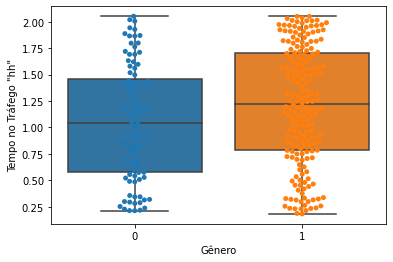

In [20]:
sns.boxplot(x = 'Gênero', y = 'Tempo no Tráfego "hh"', data = data)
sns.swarmplot(x = 'Gênero', y = 'Tempo no Tráfego "hh"', data = data)

Acima temos a disposição dos Gêneros em relação ao tempo gasto no tráfego diário.

Observa-se que o gênero feminino tem uma concentração em mais que 1h25min no tráfego.

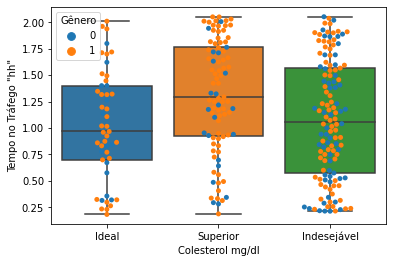

In [21]:
sns.boxplot(x = 'Colesterol mg/dl', y = 'Tempo no Tráfego "hh"', data = data)
sns.swarmplot(x = 'Colesterol mg/dl', y = 'Tempo no Tráfego "hh"', data = data, hue = 'Gênero')

In [22]:
data.groupby(['Colesterol mg/dl']).count()['Idade'].round(2)

Colesterol mg/dl
Ideal           49
Superior        91
Indesejável    132
Name: Idade, dtype: int64

Interessante observar que:

*   Apenas 18% possui níveis de colesterol como Ideal
*   33% tem níveis Superiores ao Ideal
*   49% estão com níveis Indesejáveis de colesterol

Outro ponto a considerar é que aqueles com níveis Superior ao Ideal, gastam mais tempo no tráfego diário, contudo, os que possuem níveis Indesejáveis tendem a ficar menos tempo em tráfego. Aqui nos abre uma porta para aprofundar mais na especificidade desses casos se fosse o propósito.



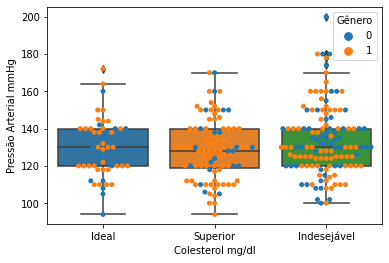

In [23]:
sns.boxplot(x = 'Colesterol mg/dl', y = 'Pressão Arterial mmHg', data = data)
sns.swarmplot(x = 'Colesterol mg/dl', y = 'Pressão Arterial mmHg', data = data, hue = 'Gênero')

Podemos perceber através do gráfico que conforme a classificação de colesterol piora, o indivíduo tende a ter uma pressão arterial sistólica superior ao considerado normal 120mmHg, ou como popularmente falamos "12 por 8".

Poderia ser feito uma classificação de PAS (Pressão Arterial Sistólica) como feito com o Colesterol, entretanto optei por não fazer para poder ver o momento em que o indivíduo está próximo de uma crise hipertensiva (PAS acima de 180mmHg)

*Pesquisas feitas na fonte: https://www.mdsaude.com/hipertensao/pressao-arterial-normal/*

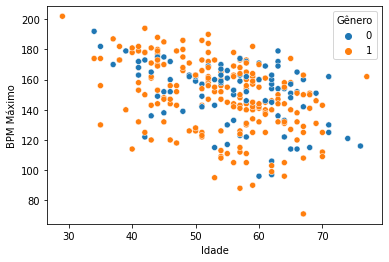

In [41]:
poss1 = sns.scatterplot(x = 'Idade', y = 'BPM Máximo', hue = 'Gênero', data = data)

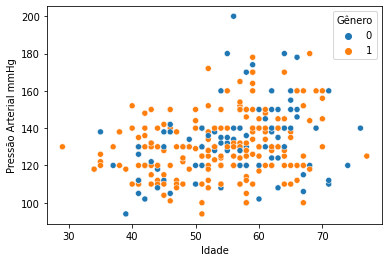

In [40]:
poss2 = sns.scatterplot(x = 'Idade', y = 'Pressão Arterial mmHg', hue = 'Gênero', data = data)

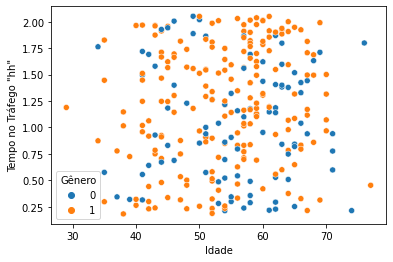

In [42]:
poss3 = sns.scatterplot(x = 'Idade', y = 'Tempo no Tráfego "hh"', hue = 'Gênero', data = data)

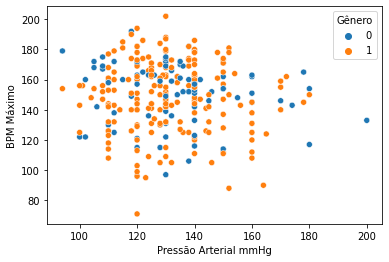

In [43]:
poss4 = sns.scatterplot(x = 'Pressão Arterial mmHg', y = 'BPM Máximo', hue = 'Gênero', data = data)

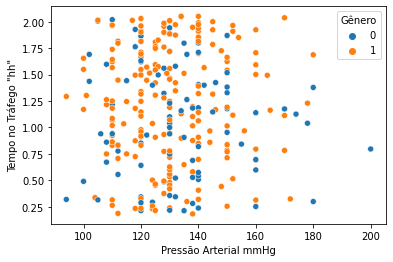

In [44]:
poss5 = sns.scatterplot(x = 'Pressão Arterial mmHg', y = 'Tempo no Tráfego "hh"', hue = 'Gênero', data = data)

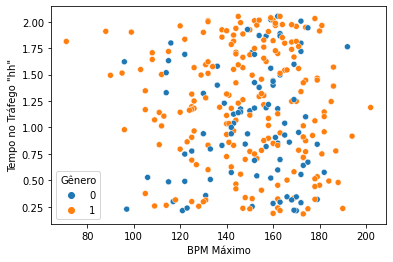

In [45]:
poss6 = sns.scatterplot(x = 'BPM Máximo', y = 'Tempo no Tráfego "hh"', hue = 'Gênero', data = data)

Criado 6 gráficos de dispersão para perceber a distribuição de gênero entre as possíveis variáveis e quais possíveis padrões.

## **4. Modelo Preditivo**

Dado o fim do EDA, iremos buscar um modelo preditivo de classificação.

Para dar início ao modelo preditivo, escolho como opção o "poss1" do EDA (possibilidade 1), este parece fornecer uma tendência de quanto maior a Idade, menor é o BPM Máximo.

Demais possibilidades, mostram disperções aleatórias mesclando os gêneros propósito do modelo a desenvolver.

In [46]:
x = data[['Idade', 'BPM Máximo']]
y = data['Gênero']

In [47]:
x.head()

,Idade,BPM Máximo
0,49,163
1,61,125
2,46,120
3,69,146
4,51,143


In [48]:
y.head()

0    0
1    1
2    1
3    1
4    1
Name: Gênero, dtype: int64

Separando as váriaveis escolhidas nos respectivos eixos e visualizando o resultado.

### **4.1 Validação Cruzada K-Fold**

A validação cruzada K-Fold vai separar o conjunto de dados em 'n' partes iguais.

* Exemplo: Parte 1 contém 10 linhas (8 linhas de treinamento e 2 linhas de teste) e assim sucessivamente para as 'n' partes.

Os objetivos da validação cruzada são para Seleção e Avaliação de modelo, sendo o primeiro mostrando o desempenho e o segundo a estimar o erro de previsão em novos dados.

In [49]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

In [50]:
kf = KFold(n_splits = 5, shuffle = True)

Como o dataset contém uma pequena quantidade de dados, irei dividir em 5 partes.

Na validação cruzada trarei a informação de desempenho da:

*   Acurácia (accuracy): taxa de acerto
*   Sensibilidade (recall): taxa de verdadeiro positivo
*   VPP ou Valor Preditivo Positivo (precision): precisão



#### **4.1.1 Regressão Logística**

A Regressão Logística tem como pressuposto variável binária para resposta, que nesse caso é: se quanto maior a idade e menor bpm máximo, esse indivíduo é 0 ou 1 (masculino ou feminino respectivamente).

In [51]:
from sklearn.linear_model import LogisticRegression 

modelo = LogisticRegression()

In [52]:
metricas = cross_validate(modelo, x, y, cv = kf, scoring = ['accuracy', 'recall', 'precision'])

In [53]:
metricas

{'fit_time': array([0.01563025, 0.0070076 , 0.00757527, 0.00997543, 0.00744891]),
 'score_time': array([0.00286627, 0.00247669, 0.00385904, 0.00480151, 0.00251865]),
 'test_accuracy': array([0.70689655, 0.60344828, 0.67241379, 0.75438596, 0.64912281]),
 'test_precision': array([0.70689655, 0.60344828, 0.67241379, 0.75438596, 0.66071429]),
 'test_recall': array([1.        , 1.        , 1.        , 1.        , 0.97368421])}

In [54]:
metricas['test_accuracy'].mean()

0.6772534785238961

In [55]:
print('Acurácia:', metricas['test_accuracy'].mean())
print('Sensibilidade:', metricas['test_recall'].mean())
print('VPP:', metricas['test_precision'].mean())

Acurácia: 0.6772534785238961
Sensibilidade: 0.9947368421052631
VPP: 0.6795717742632443


Aparentemente a acurácia e a precisão estão medianas. O que significa não ter uma boa métrica, seja de acurácia ou vpp.

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


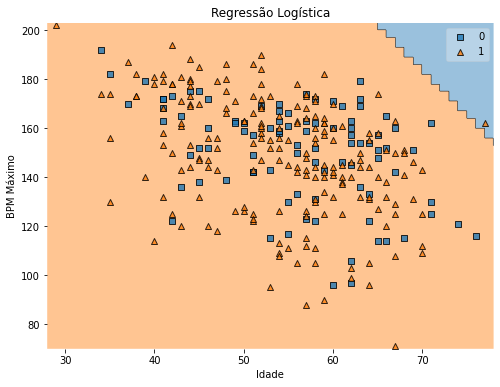

In [56]:
from mlxtend.plotting import plot_decision_regions

modelo = LogisticRegression()
modelo.fit(x, y)
 
plt.figure(figsize = (8, 6))
plot_decision_regions(x.values, y.values, clf = modelo, legend = 1)
plt.xlabel('Idade')
plt.ylabel('BPM Máximo')
plt.title('Regressão Logística')  
plt.show()

Visualizando graficamente o resultado do modelo de Regressão Logística em predizer Gêneros 0 e 1 (Masculino e Feminino respectivamente).

Noto que não foi o melhor modelo pois a linha que separa o canva em laranja e azul (laranja Feminino e Azul Masculino) está em uma região bem isolada, pegando provavelmente um outlier.

Para isso, será cogitado outro modelo.

#### **4.1.2 KNN**

O KNN (K-nearest neighbors, ou “K-vizinhos mais próximos”) irá observar a classe dos vizinhos mais próximos, em uma votação onde a maioria vence.

In [57]:
from sklearn.neighbors import KNeighborsClassifier 

modelo = KNeighborsClassifier(n_neighbors = 5)

metricas = cross_validate(modelo, x, y, cv = kf, scoring = ['accuracy', 'recall', 'precision'])

print('Acurácia:', metricas['test_accuracy'].mean())
print('Sensibilidade:', metricas['test_recall'].mean())
print('VPP:', metricas['test_precision'].mean())

Acurácia: 0.610768300060496
Sensibilidade: 0.8113089266389123
VPP: 0.6788897275882149


Escolhi por 5 vizinhos devido tamanho do dataset e proximidade aparente entre as disperções.

No KNN a:
*  Acurácia caiu 6%
*  Sensibilidade caiu 18%
*  Precisão caiu menos de 1%

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


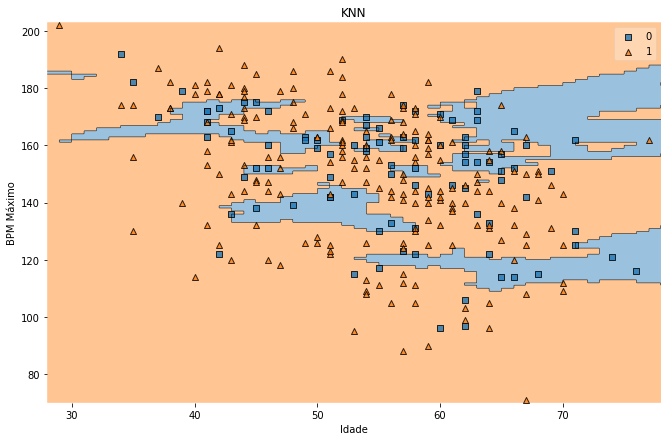

In [58]:
modelo.fit(x, y)
 
plt.figure(figsize = (11, 7))
plot_decision_regions(x.values, y.values, clf = modelo, legend = 1)
plt.xlabel('Idade')
plt.ylabel('BPM Máximo')
plt.title('KNN')  
plt.show()

Visualizando graficamente o resultado do modelo de KNN em predizer Gêneros 0 e 1 (Masculino e Feminino respectivamente).

Noto que embora o gráfico consiga criar "lagos", onde o azul (Masculino) predomina, classificando bem os gêneros, ainda não foi o melhor modelo pois não há uma linha que separa o canva em laranja e azul (laranja Feminino e Azul Masculino), os "lagos" geralmente denotam particularidades.

Para isso, será cogitado outro modelo.

#### **4.1.3 Árvore de Decisão**

Esse modelo ao tomar uma decisão, desencadeia uma ramificação com outras possibilidades.

In [59]:
from sklearn.tree import DecisionTreeClassifier

modelo = DecisionTreeClassifier(max_depth = 3)

metricas = cross_validate(modelo, x, y, cv = kf, scoring = ['accuracy', 'recall', 'precision'])

print('Acurácia:', metricas['test_accuracy'].mean())
print('Sensibilidade:', metricas['test_recall'].mean())
print('VPP:', metricas['test_precision'].mean())

Acurácia: 0.6459770114942529
Sensibilidade: 0.9020365908601203
VPP: 0.6793670969877523


Os resultados da árvore de decisão também estão medianos, mas melhor que o KNN nos três score.

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


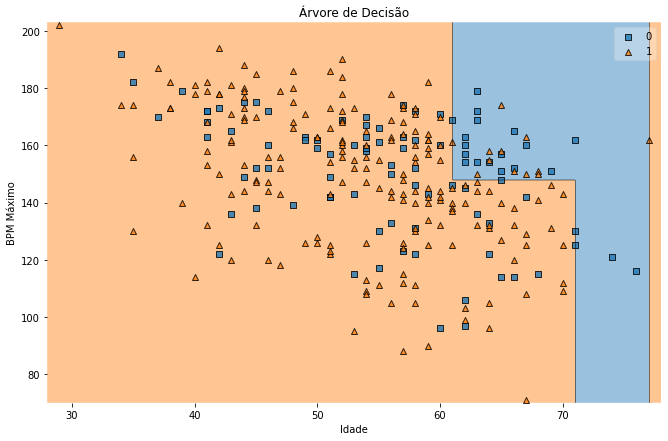

In [61]:
modelo.fit(x, y)
 
plt.figure(figsize = (11, 7))
plot_decision_regions(x.values, y.values, clf = modelo, legend = 1)
plt.xlabel('Idade')
plt.ylabel('BPM Máximo')
plt.title('Árvore de Decisão')  
plt.show()

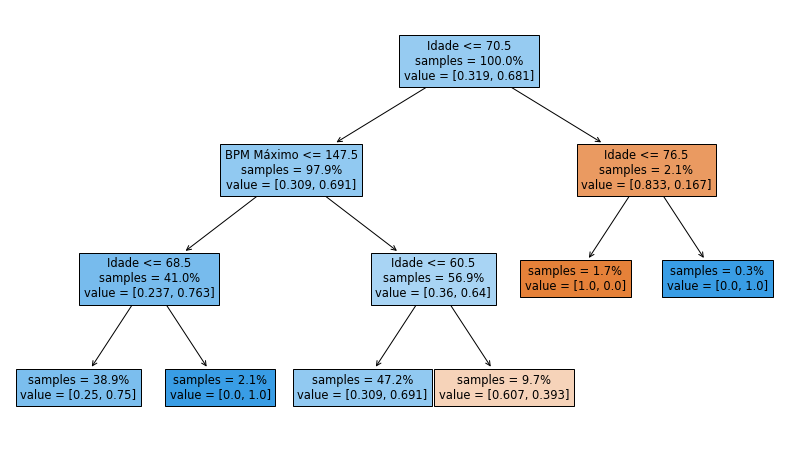

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize = (14, 8))
plot_tree(modelo, filled=True, proportion = True, impurity = False, feature_names = x.columns)
plt.show()

Embora o resultado do score da Arvore de Decisão seja menor que o da Regressão Logística, ele consegue permear e classificar melhor o gênero que os outros modelos construídos.

### **4.2 Validação Cruzada K-Fold II**

De forma um pouco mais robusta, irei reproduzir o método de validação cruzada porém ao incluir repetições consigo resultados ligeiramente diferentes do que a primeira validação cruzada.

De forma mais objetiva, a seguir irei trazer os modelos com os seus respectivos resultados de Acurácia para no final comparar qual o melhor.

In [64]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate

In [65]:
kf = RepeatedKFold(n_splits = 5, n_repeats = 10)

#### **4.2.1 Modelos Preditivos**

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [67]:
modelo = LogisticRegression()
medidas = cross_validate(modelo, x, y, cv = kf, scoring = 'accuracy')
medidas['test_score'].mean()

0.6781488203266788

In [68]:
modelo = KNeighborsClassifier(n_neighbors = 5)
medidas = cross_validate(modelo, x, y, cv = kf, scoring = 'accuracy')
medidas['test_score'].mean()

0.6035571687840291

In [69]:
modelo = DecisionTreeClassifier(max_depth = 3)
medidas = cross_validate(modelo, x, y, cv = kf, scoring = 'accuracy')
medidas['test_score'].mean()

0.6728856624319418

Olhando especificamente para a Acurácia, a Regressão Logística se mostra como o modelo mais promissor a se adotar, sendo 0,53% melhor que a Árvore de Decisão e 7% melhor que o KNN. Cabe ressaltar que a linha da Regressão Logística está em uma área afastada do canva, dando a falsa impressão que ele performa melhor que a árvore de decisão por exemplo.

### **4.3 Combinação de Modelos por Votos**

Esse método vai combinar os modelos por meio de voto.

In [70]:
from sklearn.ensemble import VotingClassifier

relog = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors = 5)
arvore = DecisionTreeClassifier(max_depth = 3)

modelos = [('Reg. Log.', relog), ('KNN', knn), ('Árvore', arvore)]

modelo = VotingClassifier(modelos, voting = 'hard')

medidas = cross_validate(modelo, x, y, cv = kf, scoring = 'accuracy')
medidas['test_score'].mean()

0.6710949788263763

In [71]:
from mlxtend.plotting import plot_decision_regions

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


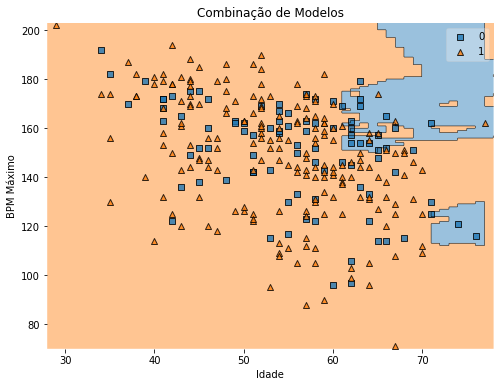

In [72]:
modelo.fit(x, y)

plt.figure(figsize = (8, 6))
plot_decision_regions(x.values, y.values, clf = modelo, legend = 1)
plt.xlabel('Idade')
plt.ylabel('BPM Máximo')
plt.title('Combinação de Modelos')
plt.show()

A combinação trouxe algo semelhante ao KNN, que relemebrando, tem possivelmente um viés de pegar particularidades.

In [73]:
from sklearn.ensemble import VotingClassifier

relog = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors = 5)
arvore = DecisionTreeClassifier(max_depth = 3)

modelos = [('Reg. Log.', relog), ('KNN', knn), ('Árvore', arvore)]

modelo = VotingClassifier(modelos, voting = 'soft')

medidas = cross_validate(modelo, x, y, cv = kf, scoring = 'accuracy')
medidas['test_score'].mean()

0.6782032667876589

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


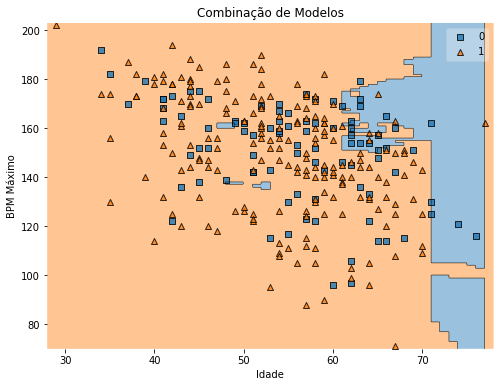

In [74]:
modelo.fit(x, y)

plt.figure(figsize = (8, 6))
plot_decision_regions(x.values, y.values, clf = modelo, legend = 1)
plt.xlabel('Idade')
plt.ylabel('BPM Máximo')
plt.title('Combinação de Modelos')
plt.show()

O voto de combinação Soft traz um modelo um pouco melhor em acurácia, 0,73% melhor, mas ainda não o ideal para classificar os gêneros.

### **4.4 Bagging**

São amostragens de um conjunto de dados, com reposição, e, em geral, do mesmo tamanho do conjunto de dados.

Ele vai enfatizar algumas amostras sorteadas em detrimento de não olhar muito para outras.

A eficiência desse método está atrelada a instabilidade dos dados, ou seja, para amostras diferentes, tem que trazer modelos diferentes, pois se trazer iguais não vai obter uma melhor perspectiva para um modelo.

In [75]:
from sklearn.ensemble import BaggingClassifier

#modelo_base = LogisticRegression()
#modelo_base = KNeighborsClassifier(n_neighbors = 5)
modelo_base = DecisionTreeClassifier(max_depth = 3)

modelo = BaggingClassifier(n_estimators = 100, base_estimator = modelo_base)
medidas = cross_validate(modelo, x, y, cv = kf, scoring = 'accuracy')
medidas['test_score'].mean()

0.6861282516636419

Utilizei o Bagging para o modelo de Árvore de Decisão, recordando que inicialmente se mostrava como melhor modelo para classificar o gênero.

Nesse método foi gerado 100 réplicas do conjunto de dados, estimou 100 árvores  de decisão e no final, o resultado da combinação dessas 100 árvores pela Acurácia média.

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


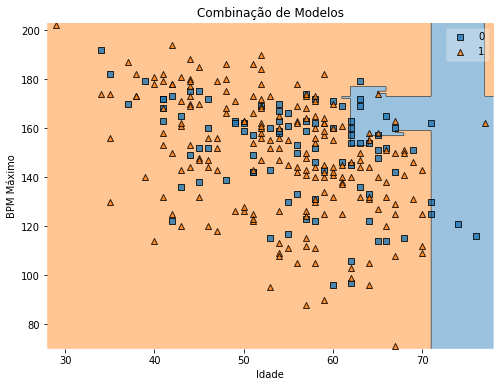

In [76]:
modelo.fit(x, y)

plt.figure(figsize = (8, 6))
plot_decision_regions(x.values, y.values, clf = modelo, legend = 1)
plt.xlabel('Idade')
plt.ylabel('BPM Máximo')
plt.title('Combinação de Modelos')
plt.show()

Consegui um melhor modelo do que os demais construídos anteriormente, pois a Acurácia está superior em relação a todos os outros até o momento.

### **4.5 Random Forests**

Em linhas gerais ela combina um número finito de modelos para obter uma melhor performance preditiva.

O algoritmo irá escolher de forma aleatória duas ou mais variáveis, e então realizar os cálculos com base nas amostras selecionadas, para definir qual dessas variáveis será no primeiro nó. No próximo nó serão outras variáveis, excluindo as já selecionadas, assim o processo de escolha não se repete.

In [80]:
from sklearn.ensemble import RandomForestClassifier

modelo = RandomForestClassifier(n_estimators = 100, max_depth = 3)
medidas = cross_validate(modelo, x, y, cv = kf, scoring = 'accuracy')
medidas['test_score'].mean()

0.6851966122202056

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


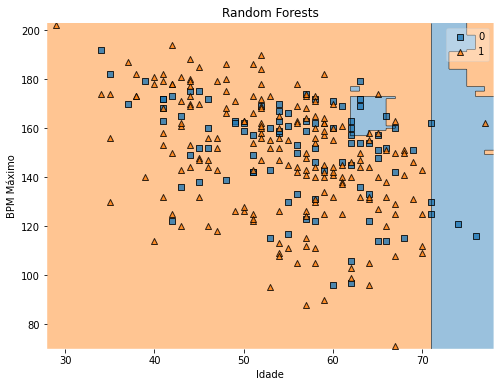

In [81]:
modelo.fit(x, y)

plt.figure(figsize = (8, 6))
plot_decision_regions(x.values, y.values, clf = modelo, legend = 1)
plt.xlabel('Idade')
plt.ylabel('BPM Máximo')
plt.title('Random Forests')
plt.show()

O Random Forest se aproximou muito do modelo em Bagging, menos que 1% de diferença. O que não faz ser o modelo mais indicado, pois, conforme gráfico, ele cria uma "ilha" com determinada particularidade.

## **5. Validação do Modelo: Quero apenas o melhor modelo ou também saber o seu erro de generalização?**

Alguns pontos serão levantos nessa penúltima parte para balancear o encontro do melhor modelo vs o erro de generalização.

Irei incorporar algumas métricas para avaliar os modelos criados como possibilidade em um tomada de decisão para qual adotar:

*  Acurácia: taxa de acerto
*  Sensibilidade: taxa de verdadeiro positivo
*  Especificidade: taxa de verdadeiro negativo
*  VPP ou Valor Preditivo Positivo: precisão de acertar quando é positivo
*  VPN ou Valor Preditivo Negativo: precisão de acertar quando é negativo
*  MCC ou Coeficiente de Correlação de Matthews: varia entre -1 e 1, quanto mais próximo entre as extremidades melhor, mais próximo de 0 significa desordem
*  Eficiência: acurácia balanceada
*  F1-Score: é a média harmônica entre Sensibilidade e VPP. 

In [82]:
modelo = VotingClassifier(modelos, voting = 'soft')
modelo.fit(x, y)
preditos = modelo.predict(x)

In [83]:
from sklearn.metrics import confusion_matrix
mc = confusion_matrix(y, preditos)

In [84]:
mc

array([[ 12,  80],
       [  6, 190]])

In [85]:
def MetricasClassBinaria(observado, predito):
    from sklearn.metrics import confusion_matrix
    mc = confusion_matrix(observado, predito)
    vn, fp, fn, vp = mc.flatten()

    pre = observado.mean()
    acc = (vn + vp)/(vn + fp + fn + vp) 
    sen = vp/(vp + fn)
    esp = vn/(vn + fp)
    vpp = vp/(vp + fp)
    vpn = vn/(vn + fn) 
    mcc = (vp*vn - fp*fn)/np.sqrt((vp + fp)*(vp + fn)*(vn + fp)*(vn + fn))
    f1s = 2*vpp*sen/(vpp + sen) 
    efi = (sen + esp)/2

    print('  Prevalência de Positivos: {:.4f}'.format(pre))
    print('                  Acurácia: {:.4f}'.format(acc))
    print('             Sensibilidade: {:.4f}'.format(sen))
    print('            Especificidade: {:.4f}'.format(esp))
    print('  Valor Preditivo Positivo: {:.4f}'.format(vpp))
    print('  Valor Preditivo Negativo: {:.4f}'.format(vpn))
    print('Coef. de Corr. de Matthews: {:.4f}'.format(mcc))
    print('                  F1-Score: {:.4f}'.format(f1s))
    print('                Eficiência: {:.4f}'.format(efi))
 
    metricas = {'prevalência': pre, 'acurácia': acc, 'sensibilidade': sen, 
            'especificidade': esp, 'vpp': vpp, 'vpn': vpn, 'mcc': mcc,
            'f1-score': f1s, 'eficiência': efi}
 
    return metricas

In [86]:
m = MetricasClassBinaria(y, preditos)

  Prevalência de Positivos: 0.6806
                  Acurácia: 0.7014
             Sensibilidade: 0.9694
            Especificidade: 0.1304
  Valor Preditivo Positivo: 0.7037
  Valor Preditivo Negativo: 0.6667
Coef. de Corr. de Matthews: 0.1923
                  F1-Score: 0.8155
                Eficiência: 0.5499


In [87]:
from sklearn.model_selection import train_test_split

xtreino, xteste, ytreino, yteste = train_test_split(x, y, test_size = 0.20)

In [88]:
modelo = LogisticRegression()
modelo.fit(xtreino, ytreino)
preditos = modelo.predict(xteste)
metricas1 = MetricasClassBinaria(yteste, preditos)

  Prevalência de Positivos: 0.7069
                  Acurácia: 0.6897
             Sensibilidade: 0.9756
            Especificidade: 0.0000
  Valor Preditivo Positivo: 0.7018
  Valor Preditivo Negativo: 0.0000
Coef. de Corr. de Matthews: -0.0853
                  F1-Score: 0.8163
                Eficiência: 0.4878


Métricas da Regressão Logística

---



In [89]:
modelo = KNeighborsClassifier(n_neighbors = 5)
modelo.fit(xtreino, ytreino)
preditos = modelo.predict(xteste)
metricas2 = MetricasClassBinaria(yteste, preditos)

  Prevalência de Positivos: 0.7069
                  Acurácia: 0.6724
             Sensibilidade: 0.8780
            Especificidade: 0.1765
  Valor Preditivo Positivo: 0.7200
  Valor Preditivo Negativo: 0.3750
Coef. de Corr. de Matthews: 0.0720
                  F1-Score: 0.7912
                Eficiência: 0.5273


Métricas do KNN

---



In [90]:
modelo = DecisionTreeClassifier(max_depth = 3)
modelo.fit(xtreino, ytreino)
preditos = modelo.predict(xteste)
metricas3 = MetricasClassBinaria(yteste, preditos)

  Prevalência de Positivos: 0.7069
                  Acurácia: 0.7069
             Sensibilidade: 0.9756
            Especificidade: 0.0588
  Valor Preditivo Positivo: 0.7143
  Valor Preditivo Negativo: 0.5000
Coef. de Corr. de Matthews: 0.0859
                  F1-Score: 0.8247
                Eficiência: 0.5172


Métricas da Árvore de Decisão

---



In [91]:
modelo = VotingClassifier(estimators = [('Reg. Log.', relog), ('KNN', knn), ('Árvore', arvore)], voting = 'hard')
modelo.fit(xtreino, ytreino)
preditos = modelo.predict(xteste)
metricas4 = MetricasClassBinaria(yteste, preditos)

  Prevalência de Positivos: 0.7069
                  Acurácia: 0.7069
             Sensibilidade: 0.9756
            Especificidade: 0.0588
  Valor Preditivo Positivo: 0.7143
  Valor Preditivo Negativo: 0.5000
Coef. de Corr. de Matthews: 0.0859
                  F1-Score: 0.8247
                Eficiência: 0.5172


Métricas do modelo combinado por votos "Hard"

---



In [92]:
modelo = VotingClassifier(estimators = [('Reg. Log.', relog), ('KNN', knn), ('Árvore', arvore)], voting = 'soft')
modelo.fit(xtreino, ytreino)
preditos = modelo.predict(xteste)
metricas5 = MetricasClassBinaria(yteste, preditos)

  Prevalência de Positivos: 0.7069
                  Acurácia: 0.6724
             Sensibilidade: 0.9268
            Especificidade: 0.0588
  Valor Preditivo Positivo: 0.7037
  Valor Preditivo Negativo: 0.2500
Coef. de Corr. de Matthews: -0.0258
                  F1-Score: 0.8000
                Eficiência: 0.4928


Métricas do modelo combinado por votos "Soft"

In [93]:
modelo = BaggingClassifier(n_estimators = 100)
modelo.fit(xtreino, ytreino)
preditos = modelo.predict(xteste)
metricas6 = MetricasClassBinaria(yteste, preditos)

  Prevalência de Positivos: 0.7069
                  Acurácia: 0.6379
             Sensibilidade: 0.7805
            Especificidade: 0.2941
  Valor Preditivo Positivo: 0.7273
  Valor Preditivo Negativo: 0.3571
Coef. de Corr. de Matthews: 0.0794
                  F1-Score: 0.7529
                Eficiência: 0.5373


Métricas do Bagging

---



In [94]:
modelo = RandomForestClassifier(n_estimators = 100, max_depth = 3) 
modelo.fit(xtreino, ytreino)
preditos = modelo.predict(xteste)
metricas7 = MetricasClassBinaria(yteste, preditos)

  Prevalência de Positivos: 0.7069
                  Acurácia: 0.6897
             Sensibilidade: 0.9512
            Especificidade: 0.0588
  Valor Preditivo Positivo: 0.7091
  Valor Preditivo Negativo: 0.3333
Coef. de Corr. de Matthews: 0.0206
                  F1-Score: 0.8125
                Eficiência: 0.5050


Métricas da Random Forests

In [95]:
resultados0 = {'Regressão Logística': list(metricas1.values()),
              '5-Vizinhos + Próximos': list(metricas2.values()),
              'Árvore de Decisão': list(metricas3.values()),
              'Combinação Hard': list(metricas4.values()),
              'Combinação Soft': list(metricas5.values()),
              'Bagging': list(metricas6.values()),
              'Random Forest': list(metricas7.values())}
              
resultados = pd.DataFrame(resultados0, index = metricas1.keys()).T
resultados

,prevalência,acurácia,sensibilidade,especificidade,vpp,vpn,mcc,f1-score,eficiência
Regressão Logística,0.706897,0.689655,0.975610,0.000000,0.701754,0.000000,-0.085289,0.816327,0.487805
5-Vizinhos + Próximos,0.706897,0.672414,0.878049,0.176471,0.720000,0.375000,0.071968,0.791209,0.527260
Árvore de Decisão,0.706897,0.706897,0.975610,0.058824,0.714286,0.500000,0.085899,0.824742,0.517217
Combinação Hard,0.706897,0.706897,0.975610,0.058824,0.714286,0.500000,0.085899,0.824742,0.517217
Combinação Soft,0.706897,0.672414,0.926829,0.058824,0.703704,0.250000,-0.025773,0.800000,0.492826
Bagging,0.706897,0.637931,0.780488,0.294118,0.727273,0.357143,0.079359,0.752941,0.537303
Random Forest,0.706897,0.689655,0.951220,0.058824,0.709091,0.333333,0.020641,0.812500,0.505022


In [96]:
resultados.sort_values(by = 'f1-score', ascending = False)

,prevalência,acurácia,sensibilidade,especificidade,vpp,vpn,mcc,f1-score,eficiência
Árvore de Decisão,0.706897,0.706897,0.975610,0.058824,0.714286,0.500000,0.085899,0.824742,0.517217
Combinação Hard,0.706897,0.706897,0.975610,0.058824,0.714286,0.500000,0.085899,0.824742,0.517217
Regressão Logística,0.706897,0.689655,0.975610,0.000000,0.701754,0.000000,-0.085289,0.816327,0.487805
Random Forest,0.706897,0.689655,0.951220,0.058824,0.709091,0.333333,0.020641,0.812500,0.505022
Combinação Soft,0.706897,0.672414,0.926829,0.058824,0.703704,0.250000,-0.025773,0.800000,0.492826
5-Vizinhos + Próximos,0.706897,0.672414,0.878049,0.176471,0.720000,0.375000,0.071968,0.791209,0.527260
Bagging,0.706897,0.637931,0.780488,0.294118,0.727273,0.357143,0.079359,0.752941,0.537303


Por último temos um DataFrame classificado qual modelo tem o melhor F1-Score, essa métrica foi adotada pois é a média harmônica conforme citado anteriormente e que viabiliza analisar em termos gerais apenas uma métrica. Claro que estudar o contexto das demais é importante.

## **6. Conclusão**

A Árvore de Decisão se mostrou o melhor modelo a adotar como classificador de gênero, contudo, diante uma amostra pequena e com métricas de resultados medianos, considero buscar mais dados que contribuam para uma melhor correlação.

Outras variáveis como Segmentação ST e Inclinação ST, relacionadas a presença de isquemia miocárdica, são condicionais que podem ser trabalhados com BPM Máximo e auxiliar na classificação de gênero, mas para isso se faz necessário um aprofundamento ou direcionamento em cardiologia para entender o conceito e funcionamento dessas condições nas pessoas para se tentar um modelo condizente.

*Fonte: https://www.bibliomed.com.br/bibliomed/books/livro2/cap/cap38.htm*
